# **Denoising Diffusion Probabilistic Models**

Toy implementation of DDPM using the original paper and huggingface notebook https://huggingface.co/learn/diffusion-course/unit1/3 

## **Imports**

In [73]:
from IPython import display
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## **Theory**
### **General**
Diffusion models are a state-of-the-art algorithm used for high-quality image generation, in the realm of generative models. As the name suggests, they are based on the idea of a diffusion process, i.e. making an image increasingly noise, which they learn to reverse. Generation begins with random noise, from which noise is gradually removed until an output image emerges.

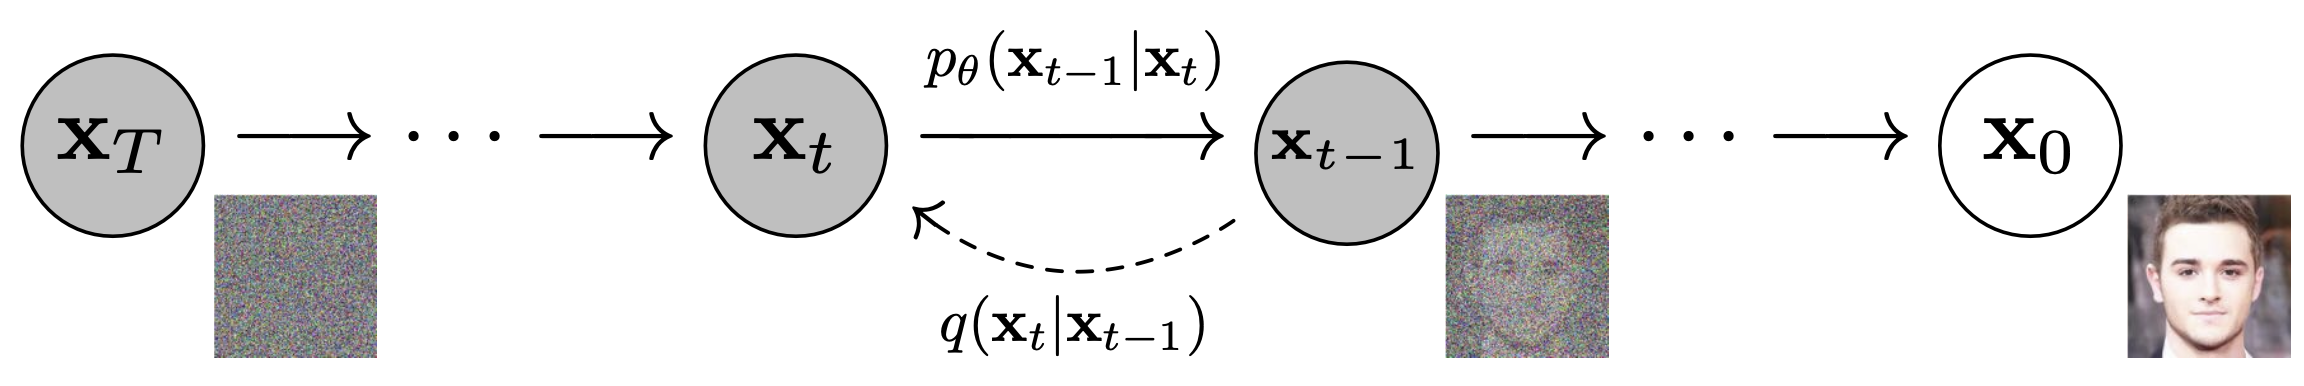

In [74]:
display.Image("ressources/diffusion_graphical_model.png")

### **Mathematical Background**
Diffusion models are parameterized Markov Chains (shown as a directed graphical model in the above figure), trained using variational inference to produce samples matching the training data after a certain number of steps $T$. The Markov chain gradually adds noise step-by-step until the original image is pure noise. The transitions in the chain are learned to reverse the diffusion process, i.e. removing the noise step-by-step to restore the original image. Gaussian noise is used, yielding conditional Gaussians in the Markov chain, e.g. $p_\theta (\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$ allowing for particularly simple neural network parameterization. 

They are latent variable models of the form:
$$ 
p_\theta (\mathbf{x}_0) := \int p_\theta (\mathbf{x}_{0:T}) d\mathbf{x}_{1:T}
$$

with the original image $\mathbf{x}_0$ and latents of same dimensionality $\mathbf{x}_{1:T}$. 

#### **Reverse Process**

The joint distribution $p_\theta (\mathbf{x}_{0:T})$ is called the reverse process and is defined as a Markov chain with learned Gaussian transitions starting at the completely corrupted image 
$$
p(\mathbf{x}_T) = \mathcal{N}(\mathbf{x}_T;\mathbf{0},\mathbf{I})
$$
which is pure Gaussian noise with mean 0 and identify covariance matrix. The joint distribution can be rewritten as:
$$ 
p_\theta (\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t=1}^{T} p_\theta (\mathbf{x}_{t-1} \vert \mathbf{x}_{t}), \qquad p_\theta (\mathbf{x}_{t-1} \vert \mathbf{x}_{t}) := \mathcal{N}(\mathbf{x}_{t-1};\boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))
$$
making the chaining of steps more clear. Note that the mean vector and covariance matrix of the conditional distribution of the image after one denoising step ($p_\theta (\mathbf{x}_{t-1} \vert \mathbf{x}_{t})$) are learned by the model.

#### **Forward (Diffusion) Process**
Diffusion models are latent variable models similar to Variational Autoencoders (VAEs), that use variational inference to find an approximate posterior $p(z \vert x)$. In diffusion models, the approximate posterior is called the forward, or diffusion, process, and is fixed to the Markov chain introduced earlier. Therefore, the approximate posterior is written as $q(\mathbf{x}_{1:T} \vert \mathbf{x}_{0})$. Therefore, the data is not linked to a latent vector, but to a Markov chain gradually corrupting the data according to a noise schedule $\beta_1, \dots, \beta_T$ that needs to be defined:
$$
q (\mathbf{x}_{1:T} \vert \mathbf{x}_{0}) = \prod_{t=1}^{T} q (\mathbf{x}_{t} \vert \mathbf{x}_{t-1}), \qquad q (\mathbf{x}_{t} \vert \mathbf{x}_{t-1}) := \mathcal{N} (\mathbf{x}_t; \sqrt{1- \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})
$$ 

### **Training Process**
The training process is divided into 5 steps:
1. **Load an image batch from the training data**
2. **Add noise in different amounts.** The models needs to be able to denoise images with varying amount of noise on them so that it can predict the direction from noise to actual image. This is important as the images are denoised graudally over a large number of steps and this needs to work for noise as well as near-clean images.
3. **Feed noisy images to model**
4. **Evaluate how well the model is denoising them**
5. **Use this information (loss) to update the model weights.**

## **Loading Data**

In [75]:
dataset = torchvision.datasets.MNIST(
    root="data/mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

In [76]:
train_dataloader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 5, 2, 1, 1, 9, 0, 6])


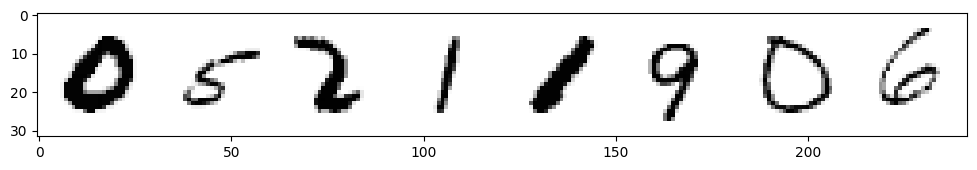

In [77]:
# retrieve first batch with images x and labels y from dataloader
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
plt.show()

One batch contains 8 images with 1 channel and 28x28 pixels each. The values are normalized between 0 and 1 (normally 0-255)

## **Adding noise**

We can write a function that takes an input image x and adds a certain amount of noise. If amnount=0, the function returns the original image. Conversely, amount=1 yields pure noise. It represents a linear interpolation between input and Gaussian noise.

In [ ]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works (unsqueeze to 4D like input)
    return x * (1 - amount) + noise * amount

torch.Size([8, 1, 1, 1])


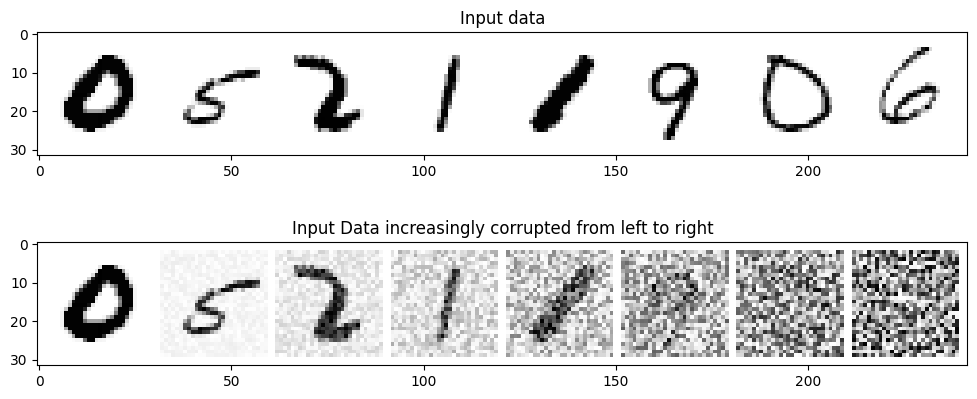

In [79]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Input Data increasingly corrupted from left to right")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")
plt.show()